In [43]:
# Author: George Russell Murray
# Date: 12/27/2018

In [4]:
# Library Imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Helpers

In [5]:
# Helper Functions 
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

# Camera Calibration

In [7]:
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, camera_matrix, distortion_coefficients, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    return ret, camera_matrix, distortion_coefficients, rvecs, tvecs
    
    #         # Draw and display the corners
    #         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    #         plt.imshow(img)


In [8]:
# Calling the calibrate_camera function to generate our camera matrix and distortion coefficients
ret, camera_matrix, distortion_coefficients, rvecs, tvecs = calibrate_camera()

# Implementing Distortion Correction

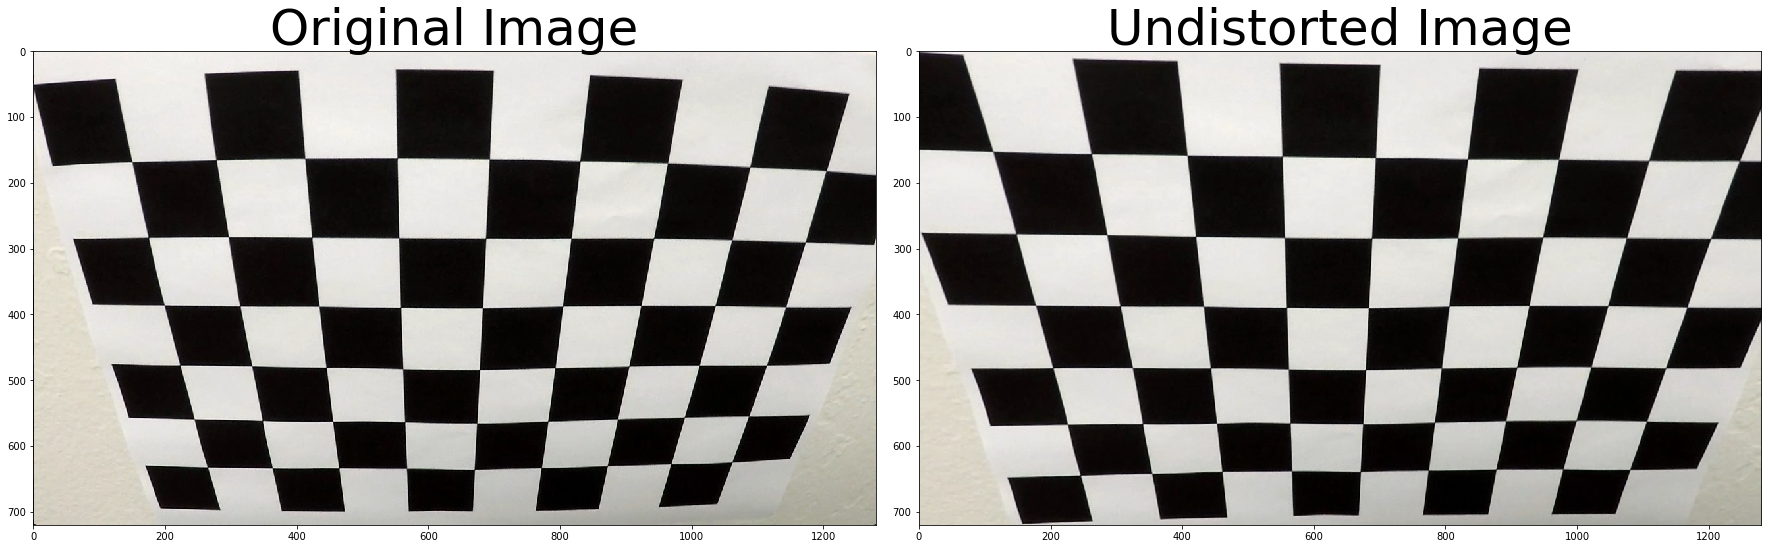

In [9]:
# Reading in Distortion Correction Image
img = mpimg.imread('camera_cal/calibration2.jpg')
# cv2 undistort call 
undistorted_img = cv2.undistort(img, camera_matrix, distortion_coefficients, None, camera_matrix)
# Outputting image using matplotlib
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
# Getting Image to Threshold
test_frame = mpimg.imread('test_images/test2.jpg')

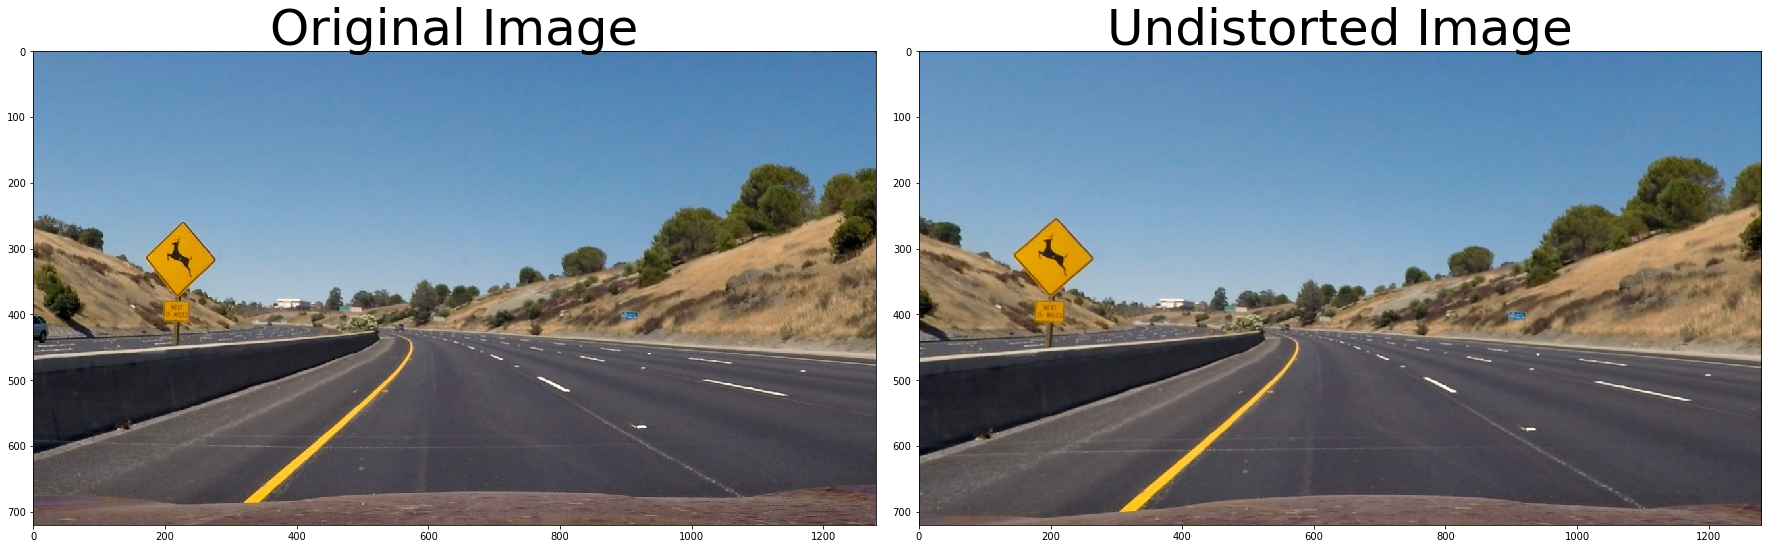

In [11]:
# Undistorting Test Image
test_undistorted_image = cv2.undistort(test_frame, camera_matrix, distortion_coefficients, None, camera_matrix)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_frame)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_undistorted_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



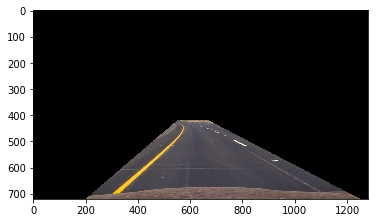

In [12]:
vertices = np.array([[(200, 720), (550, 420), (670, 420), (1250, 720)]])
masked_undistorted_img = region_of_interest(test_undistorted_image, vertices)
plt.imshow(masked_undistorted_img)

# Implementing Color & Gradient Thresholds

In [13]:
def color_gradient_threshold(undistorted_img):
#     vertices = np.array([[(200, 720), (550, 420), (670, 420), (1250, 720)]])
#     masked_undistorted_img = region_of_interest(undistorted_img, vertices)
    hls_undistorted = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
    s_channel = hls_undistorted[:, :, 2]
    l_channel = hls_undistorted[:, :, 1]
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    # Clean up noise in image by applying a Gaussian Blur
    blurred_gray = cv2.GaussianBlur(gray, (3, 3), 0)
    sobelx = cv2.Sobel(gray, cv2.cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold the gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (s_channel <= thresh_max)] = 1

    # Threshold the color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    return combined_binary



In [14]:
def sobel_thresh(img, orient='x', kernel_size=3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output
    

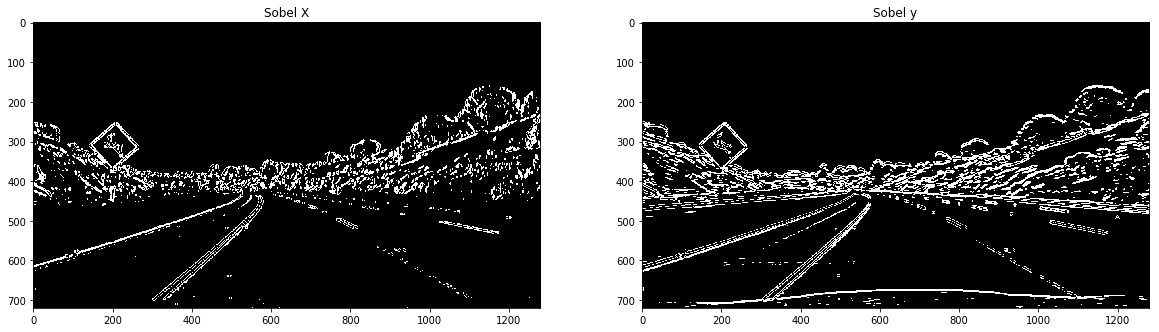

In [15]:
sobelx = sobel_thresh(test_undistorted_image, orient='x', kernel_size=15, thresh_min=30, thresh_max=100)
sobely = sobel_thresh(test_undistorted_image, orient='y', kernel_size=15, thresh_min=30, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Sobel X')
ax1.imshow(sobelx, cmap='gray')
ax2.set_title('Sobel y')
ax2.imshow(sobely, cmap='gray')

In [16]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

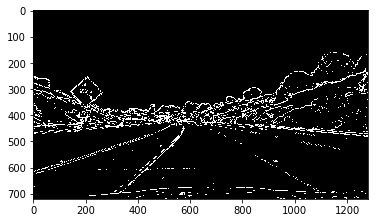

In [17]:
mag_of_thresh = mag_thresh(test_undistorted_image, sobel_kernel=3, mag_thresh=(30, 100))

plt.imshow(mag_of_thresh, cmap='gray')
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('Sobel X')
# ax1.imshow(sobelx, cmap='gray')
# ax2.set_title('Sobel y')
# ax2.imshow(sobely, cmap='gray')

In [18]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_output
    
    

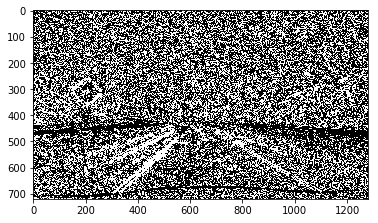

In [19]:
dir_of_gradient = dir_threshold(test_undistorted_image, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_of_gradient, cmap='gray')

In [20]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary

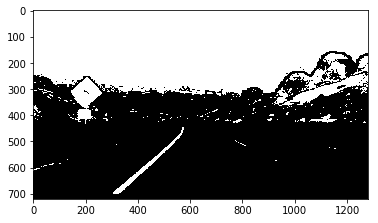

In [21]:
hls_binary = hls_select(test_undistorted_image, thresh=(90, 255))
plt.imshow(hls_binary, cmap='gray')

In [22]:
def combine_thresholds(undistorted_img):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-22-0e0cfe1e42b7>, line 2)

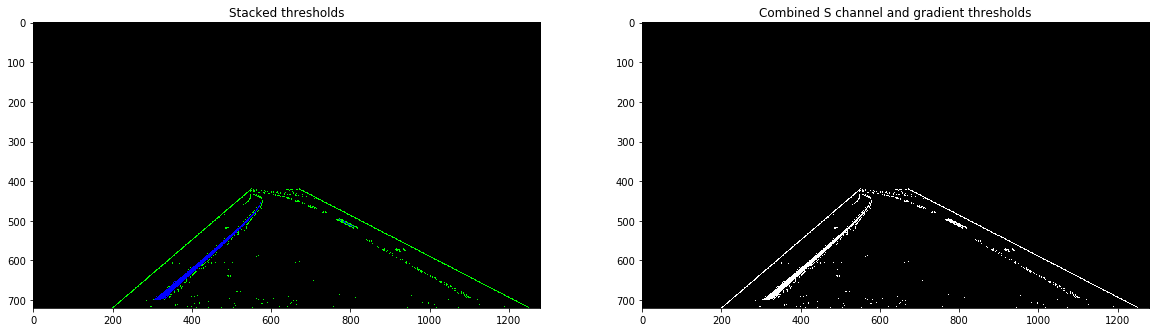

In [23]:
#thresholded_img = color_gradient_threshold(test_undistorted_image)
thresholded_img = color_gradient_threshold(masked_undistorted_img)

In [24]:
def calc_warp_points(img_height,img_width,x_center_adj=0):
    
    # calculator the vertices of the region of interest
    imshape = (img_height, img_width)
    xcenter=imshape[1]/2+x_center_adj
#     xfd=55
#     yf=450
#     xoffset=100
    xfd=54
    yf=450
    xoffset=120
    
    src = np.float32(
        [(xoffset,imshape[0]),
         (xcenter-xfd, yf), 
         (xcenter+xfd,yf), 
         (imshape[1]-xoffset,imshape[0])])
    
    # calculator the destination points of the warp
#     dst = np.float32(
#         [(xoffset,imshape[0]),
#          (xoffset,0),
#          (imshape[1]-xoffset, 0),
#         (imshape[1]-xoffset,imshape[0])])
    
    dst = np.float32(
        [(xoffset,imshape[1]),
         (xoffset,0),
         (imshape[0]-xoffset, 0),
        (imshape[0]-xoffset,imshape[1])])
        
    return src, dst

# Apply Perspective Transform

In [25]:
def apply_perspective(frame):
    
    frame_size = (frame.shape[1], frame.shape[0])
    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
#     src = np.float32([(575,464),
#                       (707,464), 
#                       (258,682), 
#                       (1049,682)])
#     dst = np.float32([(450,0),
#                       (frame_width-450,0),
#                       (450,frame_height),
#                       (frame_width-450,frame_height)])
    src, dst = calc_warp_points(frame_height, frame_width)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_frame = cv2.warpPerspective(frame, M, frame_size, flags=cv2.INTER_LINEAR)
#     plt.plot(Polygon(src).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
#     plt.imshow(warped_frame)
    f, (ax1) = plt.subplots(1, 1)
    ax1.imshow(warped_frame,cmap='gray')
#     ax1.set_xlim(420, 850)
#     ax1.set_ylim(frame_height, 0)
    return warped_frame

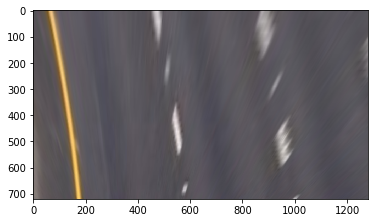

In [26]:
warped_frame = apply_perspective(test_undistorted_image)

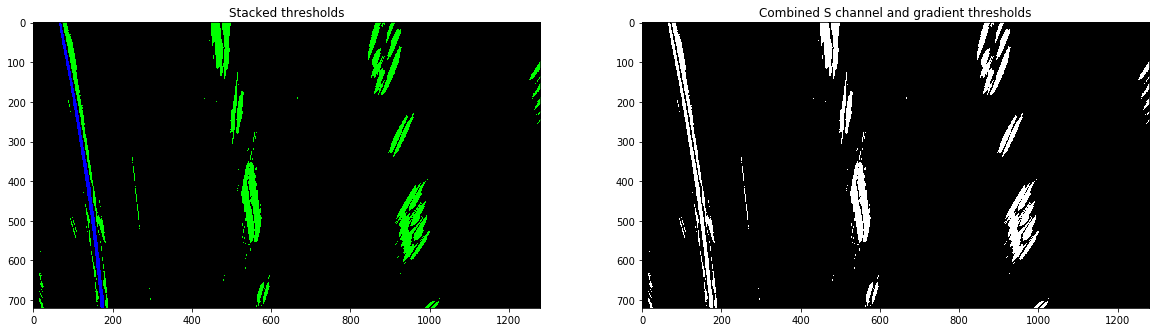

In [27]:
transformed_binary = color_gradient_threshold(warped_frame)

# Detecting Lane Pixels 

In [28]:
def generate_histogram(img):
    bottom_half = img[img.shape[0]//2:, 0:650]
    histogram = np.sum(bottom_half, axis=0)
    plt.plot(histogram)
    return histogram

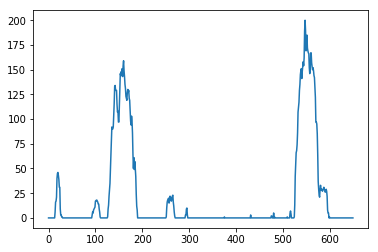

In [29]:
histogram = generate_histogram(transformed_binary)

In [39]:
def find_lane_pixels(warped_image):
    histogram = generate_histogram(warped_image)
    out_img = np.dstack((warped_image, warped_image, warped_image))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Hyperparameters
    nwindows = 10
    margin = 100
    minpix = 40
    window_height = np.int(warped_image.shape[0]//nwindows)
    
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###

        if len(good_left_inds) > minpix:
            #print("good left indexes: ", good_left_inds)
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:  
            #print("good right indexes: ", good_right_inds)
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [40]:
def fit_polynomial(warped_image):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img



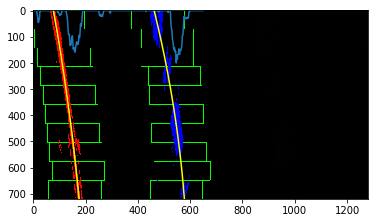

In [41]:
out_img = fit_polynomial(transformed_binary)
plt.imshow(out_img)

In [ ]:
def search_around_poly(warped_image, prev_left_fit, prev_right_fit):
    margin = 100
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                    prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                    prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                    prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
    
                                                                prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    